In [3]:
import pandas as pd
from datetime import datetime
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import numpy as np
import warnings
import sys
from pandas.tseries.offsets import BDay
from scipy import stats

### define functions

In [4]:
def get_price(ticker, start_time, end_time):
    return all_prices.loc[start_time:end_time,ticker]

def up_trend(prices,start,end,threhold):
    _price = prices[start:end]
    diff = _price.diff()
    if (sum(diff>0)/len(diff) >= threhold):
        return True
    else:
        return False

In [5]:
def weight(all_signals, code, date):
    return all_signals.loc[date-BDay(1),code]

def update_progress(job_title, progress):
    length = 20 # modify this to change the length
    block = int(round(length*progress))
    msg = "\r{0}: [{1}] {2}%".format(job_title, "#"*block + "-"*(length-block), round(progress*100, 2))
    if progress >= 1: msg += " DONE\r\n"
    sys.stdout.write(msg)
    sys.stdout.flush()

def portfolio_weight(N_long):
    long_weight = 1/N_long
    return long_weight

def portfolio_construct(N_long, all_signals, date, capital):
    weights = pd.DataFrame(index = all_prices.columns)
    amount = 0
    for code in weights.index:
        weights.loc[code,'weight'] = weight(all_signals, code, date)
    weights['prices'] = all_prices.loc[date,:]
    weights = weights.dropna()
    weights = weights[weights.weight != 0]
    
#     weights = weights.sort_values('weight', ascending = False)
    
    long_list = np.array(weights.index[:N_long])
    long_prices = weights.prices[:N_long]
    
    if (len(long_list)!=0):
        long_weight = portfolio_weight(len(long_list))
    
        amount = capital*long_weight/long_prices
#     print("bought", long_list, "at", date)
    return long_list, amount

def portfolio_value(long_list, amount, date):
    long_prices = get_price(long_list, date,date)
    return np.sum(np.array(long_prices)*np.array(amount))

# Conduct backtesting and get the net values
def backtest(all_signals, start_time, end_time,initial_capital,N_long,t,transation_cost):
    net_value = pd.DataFrame(index = all_prices.loc[start_time:end_time,:].index)
    it = 0
    long_list = []
    capital = initial_capital
    update_progress("Progress", 0)
    compute_steps = len(net_value.index)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category = RuntimeWarning)
        for date in net_value.index:
            if (it%t == 0):
                capital = capital*(1-transation_cost)
                long_list, amount = portfolio_construct(N_long,all_signals, date, capital)
                if (len(long_list) == 0):
                    capital = capital/(1-transation_cost)
                net_value.loc[date,'net value'] = capital
                it+=1
            else:
                if (len(long_list) == 0):
#                     print('!!',date)
                    net_value.loc[date,'net value'] = capital
                else:
                    present_value = portfolio_value(long_list, amount, date)
                    net_value.loc[date,'net value'] = present_value
                    if (it%t == (t-1) and np.isnan(present_value) == False):
                        capital = present_value
#                 net_value.loc[date,'net value'] = capital
                it+=1
#             print(date,capital)
            update_progress("Progress", it/compute_steps)
    net_value['MA5'] = net_value['net value'].rolling(5).mean() # 3-day moving average
    net_value['MA10'] = net_value['net value'].rolling(10).mean() # 5-day moving average
    spx = web.DataReader('SPY', 'iex', start_time, end_time).close
    spx = spx/spx[0]
    spx.index = pd.to_datetime(spx.index)
    net_value['S&P 500'] = spx
    net_value.to_excel("output_pnl.xlsx")
    net_value.plot(figsize=(16,8))
    plt.show()
    return net_value

### process data from excel

In [6]:
all_prices = pd.read_excel('Open Price.xlsx', index_col=0, header = 0, parse_dates=True, na_values = '#N/AN/A')
# all_prices = pd.read_excel('Last Price.xlsx', index_col=0, header = 0, parse_dates=True, na_values = '#N/AN/A')

In [7]:
num_neg_news = pd.read_excel('News Negative Sentiment Count.xlsx', index_col=0, header = 0, parse_dates=True, na_values = '#N/AN/A')

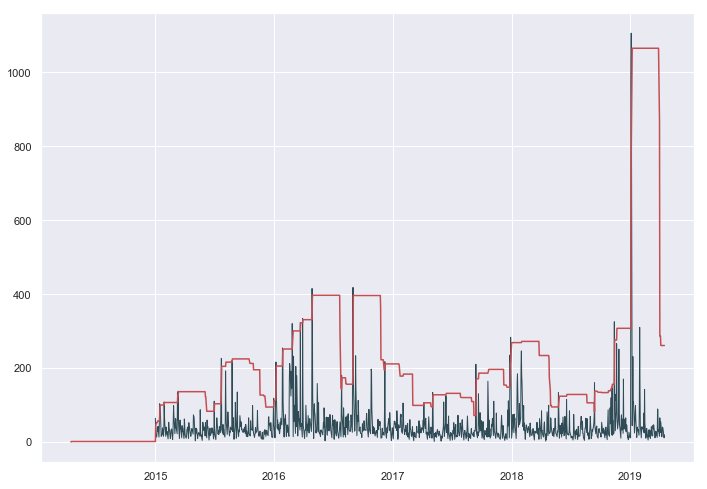

In [109]:
# ax = num_neg_news.MSFT.plot(color = (35/255,63/255,114/255),linewidth=0.5)
# ax.set_facecolor((231/255, 238/255,234/255))

# num_neg_news

import seaborn as sns
sns.set(style="darkgrid")

# Load an example dataset with long-form data
# fmri = sns.load_dataset("fmri")
sns.set(rc={'figure.figsize':(11.7,8.27)})
# Plot the responses for different events and regions
with sns.color_palette("PuBuGn_d"):
    sns.lineplot(num_neg_news.AAPL.index, num_neg_news.AAPL.values,linewidth=1)
    sns.lineplot(num_neg_news.AAPL.index, SIGNAL.AAPL.values,linewidth=1.5,color = 'r')

In [92]:
# lag = 1,
# period = 5,
def over_reaction_factor(lag):
    
    num_neg_news_POST_MKT = num_neg_news.shift(-1)
    num_neg_news_POST_MKT = num_neg_news_POST_MKT.fillna(num_neg_news_POST_MKT.min())

    NEG_0_1_signal = pd.DataFrame(columns = num_neg_news_POST_MKT.columns)
    for date in num_neg_news_POST_MKT.index:
        NEG_0_1_signal.loc[date,:] = num_neg_news_POST_MKT.loc[date-BDay(60):date,:].quantile(0.995)
    
#     NEG_0_1_signal = num_neg_news_POST_MKT.apply(stats.zscore)
    
#     NEG_0_1_signal[NEG_0_1_signal<5] = 0
#     NEG_0_1_signal[NEG_0_1_signal>=5] = 1
    
    NEG_0_1_signal = NEG_0_1_signal.shift(lag)
    
    NEG_0_1_signal = NEG_0_1_signal.fillna(0)
    
    return NEG_0_1_signal

In [93]:
SIGNAL=over_reaction_factor(2)

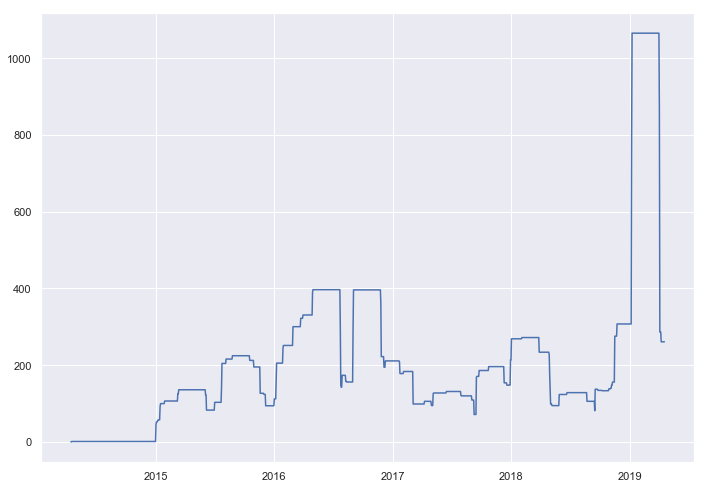

In [96]:
SIGNAL.AAPL.plot()

In [67]:
SIGNAL_2 = SIGNAL.copy()

In [69]:
SIGNAL_2[SIGNAL_2<5] = 0
SIGNAL_2[SIGNAL_2>=5] = 1

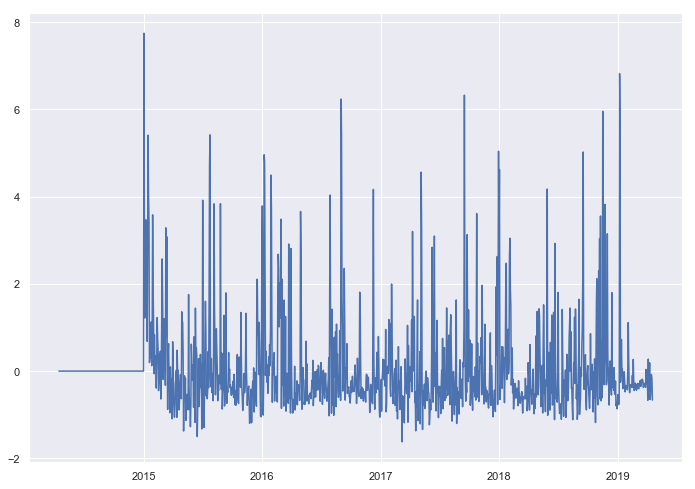

In [73]:
SIGNAL.AAPL.plot()

### backtesting

Progress: [####################] 100.0% DONE


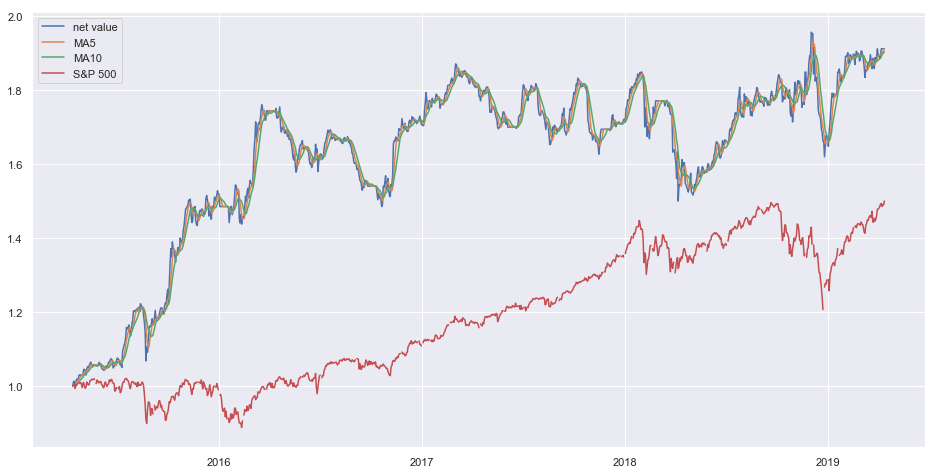

In [70]:
start_time = datetime(2015,4,14)
end_time = datetime(2019,4,12)

N_long = 5 # number of stocks to long in portfolio
t = 10 # frequency(day) of adjusting positions
initial_capital = 1 # we have one dollar in pocket to invest
transation_cost = 2/1000

pnl = backtest(SIGNAL_2, start_time,end_time,initial_capital,N_long,t,transation_cost)

In [462]:
cal_sharpe_ratio(pnl)

1.2906693290368867

In [403]:
def cal_sharpe_ratio(pnl):
    rf = 2.33/(100*252)
    daily_return = pnl['net value']/pnl.shift(1)['net value'] - 1
    return np.sqrt(252)*((daily_return-rf).mean()/daily_return.std())

In [408]:
sensitivity_test_1 = pd.DataFrame()
for N_long in [2,5,10,15,20,30]:
    for t in [5,10,15]:
        sensitivity_test_1.loc[N_long,t]=cal_sharpe_ratio(backtest(SIGNAL, start_time,end_time,initial_capital,N_long,t,transation_cost))

Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE


In [409]:
sensitivity_test_1

,5,10,15
2,0.568045,0.929164,0.183562
5,0.491517,1.290669,0.437562
10,0.457518,1.149077,0.400626
15,0.456419,1.147650,0.387545
20,0.465158,1.147650,0.387545
30,0.465158,1.147650,0.387545


In [420]:
sensitivity_test_3 = pd.DataFrame()
N_long = 10
for transation_cost in [1/1000,2/1000,3/1000,4/1000,5/1000]:
    for t in [5,10,15]:
        sensitivity_test_3.loc[transation_cost,t]=cal_sharpe_ratio(backtest(SIGNAL, start_time,end_time,initial_capital,N_long,t,transation_cost))
sensitivity_test_3

Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE


,5,10,15
0.001,0.726997,1.275986,0.479229
0.002,0.457518,1.149077,0.400626
0.003,0.189432,1.021981,0.322025
0.004,-0.076326,0.894928,0.243513
0.005,-0.338872,0.768144,0.165176


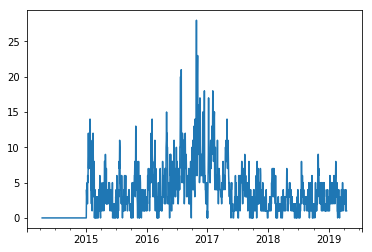

In [426]:
SIGNAL.sum(axis = 1).plot()

In [431]:
transformed_SIGNAL = SIGNAL.copy()
for i in range(0,len(transformed_SIGNAL.columns)):
    it = 0
    switch =0
    for j in range(0,len(transformed_SIGNAL.index)):
        for k in range(1,10):
            if transformed_SIGNAL.iloc[j-k,i] == 1:
                transformed_SIGNAL.iloc[j,i] = 0

transformed_SIGNAL = transformed_SIGNAL.fillna(0)

Progress: [####################] 100.0% DONE


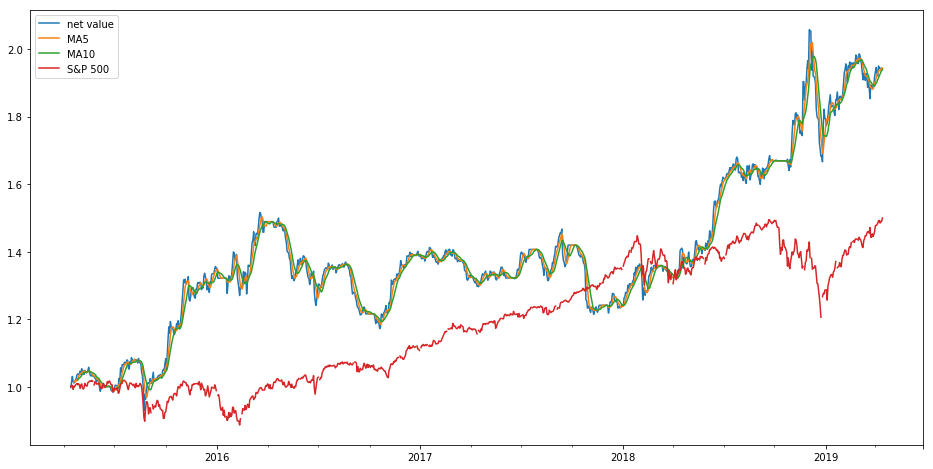

0.8023264419501945

In [435]:
start_time = datetime(2015,4,14)
end_time = datetime(2019,4,12)

N_long = 30 # number of stocks to long in portfolio
t = 10 # frequency(day) of adjusting positions
initial_capital = 1 # we have one dollar in pocket to invest
transation_cost = 2/1000

cal_sharpe_ratio(backtest(transformed_SIGNAL, start_time,end_time,initial_capital,N_long,t,transation_cost))

In [446]:
buy_in_list = pd.DataFrame(index = transformed_SIGNAL.index)
for date in buy_in_list.index:
#     buy_in_list.loc[date,:] = transformed_SIGNAL.columns[transformed_SIGNAL.loc[date,:]==1]
    print(date, ",", list(transformed_SIGNAL.columns[transformed_SIGNAL.loc[date,:]==1]))

2014-04-16 00:00:00 , []
2014-04-17 00:00:00 , []
2014-04-18 00:00:00 , []
2014-04-21 00:00:00 , []
2014-04-22 00:00:00 , []
2014-04-23 00:00:00 , []
2014-04-24 00:00:00 , []
2014-04-25 00:00:00 , []
2014-04-28 00:00:00 , []
2014-04-29 00:00:00 , []
2014-04-30 00:00:00 , []
2014-05-01 00:00:00 , []
2014-05-02 00:00:00 , []
2014-05-05 00:00:00 , []
2014-05-06 00:00:00 , []
2014-05-07 00:00:00 , []
2014-05-08 00:00:00 , []
2014-05-09 00:00:00 , []
2014-05-12 00:00:00 , []
2014-05-13 00:00:00 , []
2014-05-14 00:00:00 , []
2014-05-15 00:00:00 , []
2014-05-16 00:00:00 , []
2014-05-19 00:00:00 , []
2014-05-20 00:00:00 , []
2014-05-21 00:00:00 , []
2014-05-22 00:00:00 , []
2014-05-23 00:00:00 , []
2014-05-26 00:00:00 , []
2014-05-27 00:00:00 , []
2014-05-28 00:00:00 , []
2014-05-29 00:00:00 , []
2014-05-30 00:00:00 , []
2014-06-02 00:00:00 , []
2014-06-03 00:00:00 , []
2014-06-04 00:00:00 , []
2014-06-05 00:00:00 , []
2014-06-06 00:00:00 , []
2014-06-09 00:00:00 , []
2014-06-10 00:00:00 , []


2015-06-26 00:00:00 , ['ZBH']
2015-06-29 00:00:00 , ['APD', 'MU']
2015-06-30 00:00:00 , []
2015-07-01 00:00:00 , ['APH', 'SYY', 'WEC']
2015-07-02 00:00:00 , ['WLTW']
2015-07-03 00:00:00 , ['CAG', 'CB']
2015-07-06 00:00:00 , ['CNC']
2015-07-07 00:00:00 , []
2015-07-08 00:00:00 , ['AMD', 'HUM', 'ISRG', 'LRCX', 'RJF']
2015-07-09 00:00:00 , []
2015-07-10 00:00:00 , ['ICE', 'MSFT', 'UAL']
2015-07-13 00:00:00 , ['COTY', 'DOV', 'OXY']
2015-07-14 00:00:00 , []
2015-07-15 00:00:00 , []
2015-07-16 00:00:00 , ['CSX', 'WEC', 'YUM']
2015-07-17 00:00:00 , []
2015-07-20 00:00:00 , ['APTV', 'GRMN', 'SHW']
2015-07-21 00:00:00 , []
2015-07-22 00:00:00 , ['EBAY', 'GPC', 'IBM', 'PYPL', 'UTX', 'ZION']
2015-07-23 00:00:00 , ['C']
2015-07-24 00:00:00 , ['DFS', 'FTI', 'MSFT', 'QCOM', 'RCL', 'UNP', 'WM', 'XLNX']
2015-07-27 00:00:00 , ['AEE', 'BIIB', 'CAT', 'COF']
2015-07-28 00:00:00 , []
2015-07-29 00:00:00 , ['NSC', 'RE', 'TMK']
2015-07-30 00:00:00 , ['ETN', 'IR', 'LIN']
2015-07-31 00:00:00 , ['BWA', 'IP', 'P

2016-11-24 00:00:00 , ['BIIB', 'DE', 'LLY', 'MDT']
2016-11-25 00:00:00 , ['AES']
2016-11-28 00:00:00 , []
2016-11-29 00:00:00 , ['HIG', 'RHI', 'UNM']
2016-11-30 00:00:00 , ['APTV', 'DRI', 'HRB', 'VRTX']
2016-12-01 00:00:00 , ['ADSK', 'FFIV', 'XRX']
2016-12-02 00:00:00 , ['AJG', 'CERN', 'DG', 'IQV', 'PGR', 'PVH', 'RF', 'USB', 'ZION']
2016-12-05 00:00:00 , ['AFL', 'CCL', 'FE', 'ICE', 'JNPR', 'KR', 'NEE', 'PH', 'SBUX', 'UTX']
2016-12-06 00:00:00 , ['RJF']
2016-12-07 00:00:00 , ['EXPE', 'IR']
2016-12-08 00:00:00 , ['PFE', 'ROP']
2016-12-09 00:00:00 , ['ABT', 'AES', 'LIN', 'LLL', 'SWK', 'UHS']
2016-12-12 00:00:00 , ['ADS', 'BMY', 'HES']
2016-12-13 00:00:00 , ['CDNS', 'EOG', 'UNM']
2016-12-14 00:00:00 , ['ALXN', 'DVA', 'GWW', 'JCI', 'LMT', 'NOC', 'OKE', 'PRU', 'VIAB']
2016-12-15 00:00:00 , ['LNC']
2016-12-16 00:00:00 , ['ALK', 'HOLX', 'IQV']
2016-12-19 00:00:00 , ['GILD', 'HP', 'MYL', 'OMC', 'VLO', 'VZ']
2016-12-20 00:00:00 , ['AMG', 'AMP']
2016-12-21 00:00:00 , ['GIS', 'IPG', 'MOS']
2016-12

2017-12-08 00:00:00 , ['GE']
2017-12-11 00:00:00 , []
2017-12-12 00:00:00 , []
2017-12-13 00:00:00 , ['COG', 'DHI', 'MAT']
2017-12-14 00:00:00 , ['AEE', 'LKQ']
2017-12-15 00:00:00 , []
2017-12-18 00:00:00 , ['FOXA', 'ORCL']
2017-12-19 00:00:00 , ['CSX']
2017-12-20 00:00:00 , ['CPB', 'DIS', 'HSY']
2017-12-21 00:00:00 , []
2017-12-22 00:00:00 , ['APTV']
2017-12-25 00:00:00 , ['CELG']
2017-12-26 00:00:00 , []
2017-12-27 00:00:00 , []
2017-12-28 00:00:00 , []
2017-12-29 00:00:00 , []
2018-01-01 00:00:00 , ['BDX']
2018-01-02 00:00:00 , []
2018-01-03 00:00:00 , ['EW']
2018-01-04 00:00:00 , ['AMG', 'AWK']
2018-01-05 00:00:00 , ['D', 'INTC']
2018-01-08 00:00:00 , ['IDXX']
2018-01-09 00:00:00 , []
2018-01-10 00:00:00 , ['GOOG', 'GOOGL']
2018-01-11 00:00:00 , ['PNW']
2018-01-12 00:00:00 , []
2018-01-15 00:00:00 , ['MAR']
2018-01-16 00:00:00 , []
2018-01-17 00:00:00 , []
2018-01-18 00:00:00 , ['C', 'CSX']
2018-01-19 00:00:00 , ['GS']
2018-01-22 00:00:00 , ['ALB', 'AMZN', 'BK', 'IDXX', 'KSU']
2018

In [440]:
buy_in_list.loc[date,:]

Series([], Name: 2019-04-16 00:00:00, dtype: float64)

In [453]:
num_neg_news.CXO.iloc[160:]

2014-11-26     NaN
2014-11-27     NaN
2014-11-28     NaN
2014-12-01     NaN
2014-12-02     NaN
2014-12-03     NaN
2014-12-04     NaN
2014-12-05     NaN
2014-12-08     NaN
2014-12-09     NaN
2014-12-10     NaN
2014-12-11     NaN
2014-12-12     NaN
2014-12-15     NaN
2014-12-16     NaN
2014-12-17     NaN
2014-12-18     NaN
2014-12-19     NaN
2014-12-22     NaN
2014-12-23     NaN
2014-12-24     NaN
2014-12-25     NaN
2014-12-26     NaN
2014-12-29     NaN
2014-12-30     NaN
2014-12-31     NaN
2015-01-01     NaN
2015-01-02     1.0
2015-01-05     1.0
2015-01-06    27.0
              ... 
2019-03-06     1.0
2019-03-07     1.0
2019-03-08     1.0
2019-03-11     1.0
2019-03-12     1.0
2019-03-13     2.0
2019-03-14     2.0
2019-03-15     2.0
2019-03-18     2.0
2019-03-19     2.0
2019-03-20     2.0
2019-03-21     2.0
2019-03-22     1.0
2019-03-25     1.0
2019-03-26     1.0
2019-03-27     1.0
2019-03-28     1.0
2019-03-29     1.0
2019-04-01     1.0
2019-04-02     1.0
2019-04-03     1.0
2019-04-04  

In [459]:
start_time = datetime(2015,4,14)
end_time = datetime(2019,4,12)
initial_capital = 1 # we have one dollar in pocket to invest
transation_cost = 2/1000
N_long = 10

sensitivity_test_4 = pd.DataFrame()

for x in [1,2,3,4,5]:
    for y in [5,6,7,8,9,10]:
        temp_signal = over_reaction_factor(x)
        sensitivity_test_4.loc[x,y]=cal_sharpe_ratio(backtest(temp_signal, start_time,end_time,initial_capital,N_long,y,transation_cost))
sensitivity_test_4

Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: 

,5,6,7,8,9,10
1,0.304476,-0.097991,-0.033952,0.296716,0.408877,0.806737
2,0.457518,-0.610930,-0.266442,0.349307,0.361177,1.149077
3,0.523513,-0.457605,0.042747,0.081773,0.189071,0.687715
4,-0.119115,0.296101,0.067318,0.160243,0.249928,0.235509
5,-0.108828,0.588953,0.324985,0.105001,0.147205,0.074593


In [460]:
start_time = datetime(2015,4,14)
end_time = datetime(2019,4,12)
initial_capital = 1 # we have one dollar in pocket to invest
transation_cost = 2/1000
N_long = 10

sensitivity_test_4 = pd.DataFrame()

for x in [1,2,3,4,5]:
    for y in [11,12,13,14,15]:
        temp_signal = over_reaction_factor(x)
        sensitivity_test_4.loc[x,y]=cal_sharpe_ratio(backtest(temp_signal, start_time,end_time,initial_capital,N_long,y,transation_cost))
sensitivity_test_4

Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: [####################] 100.0% DONE
Progress: 

,11,12,13,14,15
1,0.141356,0.169439,0.879847,0.201252,0.203418
2,0.232569,0.354471,0.547431,0.237418,0.400626
3,0.405292,0.119585,0.196482,0.435754,0.825335
4,0.164592,0.655385,0.640030,0.504731,0.728307
5,0.172096,0.923771,0.511838,0.348061,-0.411366
